In [1]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [84]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 5.1 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
from matplotlib import rcParams
from pandas.io.json import json_normalize
from collections import ChainMap
import ast
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# sns.set(rc={'figure.figsize':(20,10)})
# plt.style.use(
#     "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
# )
# rcParams['figure.figsize'] = 20,10
sns.set_theme()

# Relevant functions

In [4]:
def descriptive_table(data):
  " Function that outputs descriptive data"

  sum_table = data.describe().round(1)
  sum_table = sum_table.T
  return sum_table

def flattened_cols(col_name):
  """
  extracts nested dict, returns df of them
  """
  dictionary_data = asset_df[col_name].to_dict()
  dist_flat = []

  for key, value in dictionary_data.items():
    dist_flat.append(value)

  dictionary_clean = []  #string dict to dict 
  for i in dist_flat:
    dictionary_clean.append(ast.literal_eval((i)))

  flattend_df = pd.DataFrame(dictionary_clean)
  return flattend_df

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    

# data cleaning

In [5]:
# flaggin consensus
# asset_df["consensus__general_consensus_mechanism"].fillna(" ", inplace=True)
# asset_df["PROOF-OF-WORK"] = [1 if "PROOF-OF-WORK" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["DELEGATED PROOF-OF-STAKE"] = [1 if "DELEGATED PROOF-OF-STAKE" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["HYBRID POW & POS"] = [1 if "HYBRID POW & POS" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["PROOF-OF-STAKE, DAG"] = [1 if "PROOF-OF-STAKE, DAG" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["DAG"] = [1 if "DAG" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["PROOF-OF-WORK, OTHER"] = [1 if "PROOF-OF-WORK, OTHER" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["PROOF-OF-STAKE, OTHER"] = [1 if "PROOF-OF-STAKE, OTHER" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["HYBRID POW & DPOS"] = [1 if "HYBRID POW & DPOS" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]

# asset_df['consensus__general_consensus_mechanism'] = asset_df['consensus__general_consensus_mechanism'].str.upper()
# asset_df['consensus__general_consensus_mechanism'] = asset_df['consensus__general_consensus_mechanism'].str.strip()
# asset_df['consensus__general_consensus_mechanism'].replace( { r"OTHER, PROOF-OF-WORK" : 'PROOF-OF-WORK, OTHER' }, inplace= True, regex = True)

#flattened_assets = flattened_assets.join(fund_df)

# Initial Data EDA

In [6]:
asset_df = pd.read_csv('/content/super_super_final_crypto.csv')
assets_fundraise = pd.read_csv('/content/assets_fundraise.csv')

In [7]:
descstats_assetfund = descriptive_table(assets_fundraise)
descstats_assetfund 

,count,mean,std,min,25%,50%,75%,max
Total Raised,180.0,5.807500e+07,3.239694e+08,72355.0,4812500.0,14925000.0,32211953.5,4.196874e+09
Total supply,203.0,9.919612e+11,9.851137e+12,212503.0,38887609.5,100000000.0,640243508.5,9.999900e+13
Private/Pre-sale,67.0,3.662030e+09,1.871633e+10,1450000.0,37850000.0,133333334.0,725700000.0,1.498500e+11
Public sale,103.0,1.950093e+11,1.970562e+12,30000.0,10000000.0,47000000.0,193863734.5,1.999980e+13


Text(0.5, 1.0, 'Total raised per token (All_time)')

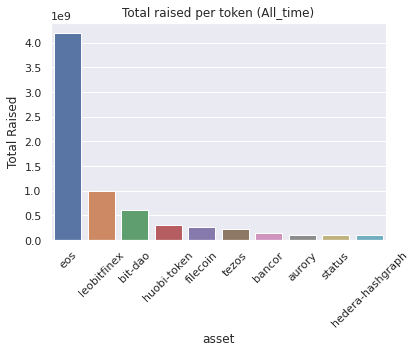

In [8]:
# ico barplot
highest_raised = assets_fundraise.sort_values(by='Total Raised',ascending=False).head(10)
ax = sns.barplot(x="asset", y="Total Raised", data=highest_raised.head(10))
ax.set_xticklabels(labels = highest_raised.asset,rotation=45)
ax.set_title("Total raised per token (All_time)", loc="center")

In [9]:
#types of funding
assets_fundraise['R1 type'].unique()

array(['Private ', 'ICO ', 'Private/Pre-sale ', 'IEO ', 'IDO ', nan,
       'Seed ', 'Private 2 '], dtype=object)

Text(0.5, 1.0, 'Total raised from ICO per token (r1)')

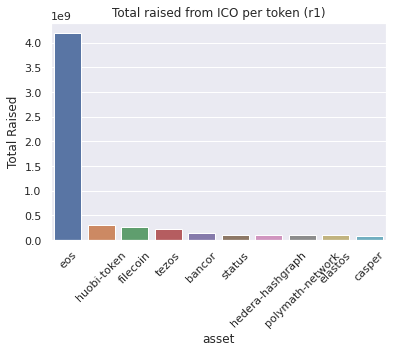

In [10]:
#test_assets_fundraise = assets_fundraise.str.strip()
assets_fundraise['R1 type'] = assets_fundraise['R1 type'].str.strip()
highest_raised_ico_r1 = assets_fundraise[assets_fundraise['R1 type'] == "ICO"]
highest_raised_ico_r1 = highest_raised_ico_r1.sort_values(by='Total Raised',ascending=False).head(10)
ax = sns.barplot(x="asset", y="Total Raised", data=highest_raised_ico_r1.head(10))
ax.set_xticklabels(labels = highest_raised_ico_r1.asset,rotation=45)
ax.set_title("Total raised from ICO per token (r1)", loc="center")


# Mutual information score

In [11]:
# rename col name for consistency
#df.rename(columns = {'old_col1':'new_col1', 'old_col2':'new_col2'}, inplace = True)

asset_df.rename(columns = {'name':'asset',}, inplace = True)
asset_df.head(3)

,Unnamed: 0,Unnamed: 0.1,asset,symbol,price_usd,price_btc,price_eth,volume_last_24_hours,real_volume_last_24_hours,volume_last_24_hours_overstatement_multiple,percent_change_usd_last_1_hour,percent_change_btc_last_1_hour,percent_change_eth_last_1_hour,percent_change_usd_last_24_hours,percent_change_btc_last_24_hours,percent_change_eth_last_24_hours,ohlcv_last_1_hour__open,ohlcv_last_1_hour__high,ohlcv_last_1_hour__low,ohlcv_last_1_hour__close,ohlcv_last_1_hour__volume,ohlcv_last_24_hour__open,ohlcv_last_24_hour__high,ohlcv_last_24_hour__low,ohlcv_last_24_hour__close,ohlcv_last_24_hour__volume,last_trade_at,rank,marketcap_dominance_percent,current_marketcap_usd,y_2050_marketcap_usd,y_plus10_marketcap_usd,liquid_marketcap_usd,volume_turnover_last_24_hours_percent,realized_marketcap_usd,outstanding_marketcap_usd,y_2050,y_plus10,liquid,circulating,y_2050_issued_percent,annual_inflation_percent,stock_to_flow,y_plus10_issued_percent,supply_revived_90d,sale_proceeds_usd,sale_start_date,sale_end_date,roi_since_sale_usd_percent,roi_since_sale_btc_percent,roi_since_sale_eth_percent,stars,watchers,commits_last_3_months,commits_last_1_year,lines_added_last_3_months,lines_added_last_1_year,lines_deleted_last_3_months,lines_deleted_last_1_year,percent_change_last_1_week,percent_change_last_1_month,percent_change_last_3_months,percent_change_last_1_year,percent_change_btc_last_1_week,percent_change_btc_last_1_month,percent_change_btc_last_3_months,percent_change_btc_last_1_year,percent_change_eth_last_1_week,percent_change_eth_last_1_month,percent_change_eth_last_3_months,percent_change_eth_last_1_year,percent_change_month_to_date,percent_change_quarter_to_date,percent_change_year_to_date,2021_usd_percent,2020_usd_percent,2019_usd_percent,2018_usd_percent,2017_usd_percent,2016_usd_percent,2015_usd_percent,2014_usd_percent,2013_usd_percent,2012_usd_percent,2011_usd_percent,sharpe_ratios__last_30_days,sharpe_ratios__last_90_days,sharpe_ratios__last_1_year,sharpe_ratios__last_3_years,volatility_stats__volatility_last_30_days,volatility_stats__volatility_last_90_days,volatility_stats__volatility_last_1_year,volatility_stats__volatility_last_3_years,supply_active_10y,supply_active_180d,supply_active_1d,supply_active_1y,supply_active_1y_percent,supply_active_2y,supply_active_30d,supply_active_3y,supply_active_4y,supply_active_5y,supply_active_7d,supply_active_90d,supply_active_ever,outstanding,supply_revived_1y,supply_revived_2y,supply_revived_30d,supply_revived_3y,supply_revived_4y,supply_revived_5y,supply_revived_7d,supply_in_addresses_balance_greater_0_001_native_units,supply_in_addresses_balance_greater_0_01_native_units,supply_in_addresses_balance_greater_0_1_native_units,supply_in_addresses_balance_greater_1_usd,supply_in_addresses_balance_greater_10_usd,supply_in_addresses_balance_greater_100_usd,supply_in_addresses_balance_greater_100k_usd,supply_in_addresses_balance_greater_100k_native_units,supply_in_addresses_balance_greater_100_native_units,supply_in_addresses_balance_greater_10k_usd,supply_in_addresses_balance_greater_10k_native_units,supply_in_addresses_balance_greater_10m_usd,supply_in_addresses_balance_greater_10_native_units,supply_in_addresses_balance_greater_1k_usd,supply_in_addresses_balance_greater_1k_native_units,supply_in_addresses_balance_greater_1m_usd,supply_in_addresses_balance_greater_1m_native_units,supply_in_addresses_balance_greater_1_native_units,supply_in_contracts_usd,supply_in_contracts_native_units,supply_shielded,supply_in_top_100_addresses,supply_in_top_10_percent_addresses,supply_in_top_1_percent_addresses,supply_in_utxo_in_loss,supply_in_utxo_in_profit,token__token_name,token__token_type,token__token_address,token__token_usage,token__token_usage_details,general__launch_style,general__launch_details,fundraising__sales_rounds,fundraising__sales_documents,fundraising__sales_treasury_accounts,fundraising__treasury_policies,fundraising__projected_use_of_sales_proceeds,initial_distribution__initial_supply,initial_

In [12]:
# check missing values as there are alot before we run mi score
missing_values_count = asset_df.isnull().sum().sort_values(ascending=False)
missing_values_count.head(10)

lines_added_last_3_months                  500
lines_deleted_last_1_year                  500
roi_since_sale_btc_percent                 500
commits_last_1_year                        500
lines_added_last_1_year                    500
roi_since_sale_usd_percent                 500
sale_end_date                              500
sale_start_date                            500
native_treasury__treasury_usage_details    500
ohlcv_last_1_hour                          500
dtype: int64

In [13]:
assets_fundraise.isnull().sum().sort_values(ascending=False).tail(10)

Public sale     100
R1 Raise         48
Total Raised     23
R1 Price         19
R1 ROI           19
R1 ATH ROI       19
R1 date          14
R1 type          13
Total supply      0
asset             0
dtype: int64

In [14]:
total_cells = np.product(asset_df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

52.00733944954128


## combine dataset asset fundraise with asset as there are too many missing values

In [15]:
# ensuring they all have same name
assets_fundraise['asset'] = assets_fundraise['asset'].str.lower()
asset_df['asset'] = asset_df['asset'].str.lower()

assets_fundraise['asset'] = assets_fundraise['asset'].str.strip()
asset_df['asset'] = asset_df['asset'].str.strip()

In [16]:
asset_df.head(3)

,Unnamed: 0,Unnamed: 0.1,asset,symbol,price_usd,price_btc,price_eth,volume_last_24_hours,real_volume_last_24_hours,volume_last_24_hours_overstatement_multiple,percent_change_usd_last_1_hour,percent_change_btc_last_1_hour,percent_change_eth_last_1_hour,percent_change_usd_last_24_hours,percent_change_btc_last_24_hours,percent_change_eth_last_24_hours,ohlcv_last_1_hour__open,ohlcv_last_1_hour__high,ohlcv_last_1_hour__low,ohlcv_last_1_hour__close,ohlcv_last_1_hour__volume,ohlcv_last_24_hour__open,ohlcv_last_24_hour__high,ohlcv_last_24_hour__low,ohlcv_last_24_hour__close,ohlcv_last_24_hour__volume,last_trade_at,rank,marketcap_dominance_percent,current_marketcap_usd,y_2050_marketcap_usd,y_plus10_marketcap_usd,liquid_marketcap_usd,volume_turnover_last_24_hours_percent,realized_marketcap_usd,outstanding_marketcap_usd,y_2050,y_plus10,liquid,circulating,y_2050_issued_percent,annual_inflation_percent,stock_to_flow,y_plus10_issued_percent,supply_revived_90d,sale_proceeds_usd,sale_start_date,sale_end_date,roi_since_sale_usd_percent,roi_since_sale_btc_percent,roi_since_sale_eth_percent,stars,watchers,commits_last_3_months,commits_last_1_year,lines_added_last_3_months,lines_added_last_1_year,lines_deleted_last_3_months,lines_deleted_last_1_year,percent_change_last_1_week,percent_change_last_1_month,percent_change_last_3_months,percent_change_last_1_year,percent_change_btc_last_1_week,percent_change_btc_last_1_month,percent_change_btc_last_3_months,percent_change_btc_last_1_year,percent_change_eth_last_1_week,percent_change_eth_last_1_month,percent_change_eth_last_3_months,percent_change_eth_last_1_year,percent_change_month_to_date,percent_change_quarter_to_date,percent_change_year_to_date,2021_usd_percent,2020_usd_percent,2019_usd_percent,2018_usd_percent,2017_usd_percent,2016_usd_percent,2015_usd_percent,2014_usd_percent,2013_usd_percent,2012_usd_percent,2011_usd_percent,sharpe_ratios__last_30_days,sharpe_ratios__last_90_days,sharpe_ratios__last_1_year,sharpe_ratios__last_3_years,volatility_stats__volatility_last_30_days,volatility_stats__volatility_last_90_days,volatility_stats__volatility_last_1_year,volatility_stats__volatility_last_3_years,supply_active_10y,supply_active_180d,supply_active_1d,supply_active_1y,supply_active_1y_percent,supply_active_2y,supply_active_30d,supply_active_3y,supply_active_4y,supply_active_5y,supply_active_7d,supply_active_90d,supply_active_ever,outstanding,supply_revived_1y,supply_revived_2y,supply_revived_30d,supply_revived_3y,supply_revived_4y,supply_revived_5y,supply_revived_7d,supply_in_addresses_balance_greater_0_001_native_units,supply_in_addresses_balance_greater_0_01_native_units,supply_in_addresses_balance_greater_0_1_native_units,supply_in_addresses_balance_greater_1_usd,supply_in_addresses_balance_greater_10_usd,supply_in_addresses_balance_greater_100_usd,supply_in_addresses_balance_greater_100k_usd,supply_in_addresses_balance_greater_100k_native_units,supply_in_addresses_balance_greater_100_native_units,supply_in_addresses_balance_greater_10k_usd,supply_in_addresses_balance_greater_10k_native_units,supply_in_addresses_balance_greater_10m_usd,supply_in_addresses_balance_greater_10_native_units,supply_in_addresses_balance_greater_1k_usd,supply_in_addresses_balance_greater_1k_native_units,supply_in_addresses_balance_greater_1m_usd,supply_in_addresses_balance_greater_1m_native_units,supply_in_addresses_balance_greater_1_native_units,supply_in_contracts_usd,supply_in_contracts_native_units,supply_shielded,supply_in_top_100_addresses,supply_in_top_10_percent_addresses,supply_in_top_1_percent_addresses,supply_in_utxo_in_loss,supply_in_utxo_in_profit,token__token_name,token__token_type,token__token_address,token__token_usage,token__token_usage_details,general__launch_style,general__launch_details,fundraising__sales_rounds,fundraising__sales_documents,fundraising__sales_treasury_accounts,fundraising__treasury_policies,fundraising__projected_use_of_sales_proceeds,initial_distribution__initial_supply,initial_

In [17]:
combined_df = pd.merge(asset_df,assets_fundraise,on='asset',how='outer')
combined_df.head(3)

,Unnamed: 0,Unnamed: 0.1,asset,symbol,price_usd,price_btc,price_eth,volume_last_24_hours,real_volume_last_24_hours,volume_last_24_hours_overstatement_multiple,percent_change_usd_last_1_hour,percent_change_btc_last_1_hour,percent_change_eth_last_1_hour,percent_change_usd_last_24_hours,percent_change_btc_last_24_hours,percent_change_eth_last_24_hours,ohlcv_last_1_hour__open,ohlcv_last_1_hour__high,ohlcv_last_1_hour__low,ohlcv_last_1_hour__close,ohlcv_last_1_hour__volume,ohlcv_last_24_hour__open,ohlcv_last_24_hour__high,ohlcv_last_24_hour__low,ohlcv_last_24_hour__close,ohlcv_last_24_hour__volume,last_trade_at,rank,marketcap_dominance_percent,current_marketcap_usd,y_2050_marketcap_usd,y_plus10_marketcap_usd,liquid_marketcap_usd,volume_turnover_last_24_hours_percent,realized_marketcap_usd,outstanding_marketcap_usd,y_2050,y_plus10,liquid,circulating,y_2050_issued_percent,annual_inflation_percent,stock_to_flow,y_plus10_issued_percent,supply_revived_90d,sale_proceeds_usd,sale_start_date,sale_end_date,roi_since_sale_usd_percent,roi_since_sale_btc_percent,roi_since_sale_eth_percent,stars,watchers,commits_last_3_months,commits_last_1_year,lines_added_last_3_months,lines_added_last_1_year,lines_deleted_last_3_months,lines_deleted_last_1_year,percent_change_last_1_week,percent_change_last_1_month,percent_change_last_3_months,percent_change_last_1_year,percent_change_btc_last_1_week,percent_change_btc_last_1_month,percent_change_btc_last_3_months,percent_change_btc_last_1_year,percent_change_eth_last_1_week,percent_change_eth_last_1_month,percent_change_eth_last_3_months,percent_change_eth_last_1_year,percent_change_month_to_date,percent_change_quarter_to_date,percent_change_year_to_date,2021_usd_percent,2020_usd_percent,2019_usd_percent,2018_usd_percent,2017_usd_percent,2016_usd_percent,2015_usd_percent,2014_usd_percent,2013_usd_percent,2012_usd_percent,2011_usd_percent,sharpe_ratios__last_30_days,sharpe_ratios__last_90_days,sharpe_ratios__last_1_year,sharpe_ratios__last_3_years,volatility_stats__volatility_last_30_days,volatility_stats__volatility_last_90_days,volatility_stats__volatility_last_1_year,volatility_stats__volatility_last_3_years,supply_active_10y,supply_active_180d,supply_active_1d,supply_active_1y,supply_active_1y_percent,supply_active_2y,supply_active_30d,supply_active_3y,supply_active_4y,supply_active_5y,supply_active_7d,supply_active_90d,supply_active_ever,outstanding,supply_revived_1y,supply_revived_2y,supply_revived_30d,supply_revived_3y,supply_revived_4y,supply_revived_5y,supply_revived_7d,supply_in_addresses_balance_greater_0_001_native_units,supply_in_addresses_balance_greater_0_01_native_units,supply_in_addresses_balance_greater_0_1_native_units,supply_in_addresses_balance_greater_1_usd,supply_in_addresses_balance_greater_10_usd,supply_in_addresses_balance_greater_100_usd,supply_in_addresses_balance_greater_100k_usd,supply_in_addresses_balance_greater_100k_native_units,supply_in_addresses_balance_greater_100_native_units,supply_in_addresses_balance_greater_10k_usd,supply_in_addresses_balance_greater_10k_native_units,supply_in_addresses_balance_greater_10m_usd,supply_in_addresses_balance_greater_10_native_units,supply_in_addresses_balance_greater_1k_usd,supply_in_addresses_balance_greater_1k_native_units,supply_in_addresses_balance_greater_1m_usd,supply_in_addresses_balance_greater_1m_native_units,supply_in_addresses_balance_greater_1_native_units,supply_in_contracts_usd,supply_in_contracts_native_units,supply_shielded,supply_in_top_100_addresses,supply_in_top_10_percent_addresses,supply_in_top_1_percent_addresses,supply_in_utxo_in_loss,supply_in_utxo_in_profit,token__token_name,token__token_type,token__token_address,token__token_usage,token__token_usage_details,general__launch_style,general__launch_details,fundraising__sales_rounds,fundraising__sales_documents,fundraising__sales_treasury_accounts,fundraising__treasury_policies,fundraising__projected_use_of_sales_proceeds,initial_distribution__initial_supply,initial_

In [18]:
combined_df['start_year'] = np.where(combined_df['start_year'].isnull() == True, combined_df['initial_distribution__genesis_block_year'], combined_df['start_year'])

In [19]:
combined_df = combined_df[combined_df['start_year'].notna()]

In [20]:
#combined_df.to_csv('super_super_super_final.csv')

In [21]:
#combined_df.isnull().sum().sort_values(ascending=False).head(1000)

In [22]:
#combined_df.isnull().sum().sort_values(ascending=False)

In [23]:
combined_df = combined_df.loc[:, combined_df.isin([' ','NULL',np.nan]).mean() < 1]

In [24]:
combined_df = combined_df.drop(columns=['Unnamed: 0.1','Unnamed: 0'])

In [25]:
combined_df.shape

(209, 249)

## Impute missing data

In [26]:
#fill 0 for certain cols
combined_df['general__launch_style'] = combined_df['general__launch_style'].fillna('launch_not_specified') # only 52 is missing so we can impute null value 'not specified'
combined_df['supply__general_emission_type'] = combined_df['supply__general_emission_type'].fillna('emission_not_specified') # 52 missing again, replace na with not specified
combined_df['supply__precise_emission_type'] = combined_df['supply__precise_emission_type'].fillna('precise_emission_not_specified')
combined_df['supply__is_capped_supply'] = combined_df['supply__is_capped_supply'].fillna('supply_cap_not_specified')
combined_df[['allocated_to_organization_or_founders_percentage','allocated_to_investors_percentage']] = combined_df[['allocated_to_organization_or_founders_percentage','allocated_to_investors_percentage']].fillna(0)
combined_df['R1 type'] = combined_df['R1 type'].fillna('R1_type_not_specied')

In [27]:
combined_df['consensus__general_consensus_mechanism'] = combined_df['consensus__general_consensus_mechanism'].replace(r'^\s*$', np.NaN, regex=True)
combined_df['consensus__general_consensus_mechanism'] = combined_df['consensus__general_consensus_mechanism'].fillna('Consensus_mechanism_notspecified')

In [28]:
dropped_cols = ['outstanding_marketcap_usd','ohlcv_last_24_hour__volume','y_plus10_marketcap_usd','liquid_marketcap_usd','token__token_address',
                'last_trade_at','volume_last_24_hours_overstatement_multiple','price_eth','price_btc','price_usd','real_volume_last_24_hours',
                'volume_last_24_hours','symbol','token__token_usage','token__token_usage_details','general__launch_details',
                'fundraising__sales_rounds','fundraising__sales_documents','fundraising__sales_treasury_accounts','fundraising__treasury_policies','fundraising__projected_use_of_sales_proceeds',
                'initial_distribution__token_distribution_date',
                'initial_distribution__genesis_block_date','supply__supply_curve_details','consensus__consensus_details','consensus__mining_algorithm',
                'consensus__next_halving_date','governance_details','onchain_governance__onchain_governance_type',
                'onchain_governance__onchain_governance_details','title','start_date','type','details','end_date',
                'restricted_jurisdictions','R1 ROI','R2 ROI','R3 ROI','R4 ROI','R5 ROI','R1 ATH ROI','R2 ATH ROI','R3 ATH ROI','R4 ATH ROI','R5 ATH ROI','rank','marketcap_dominance_percent']

# Check missing values in combined_df

potentially useful columns

* general__launch_style
* initial_distribution__initial_supply
* supply__general_emission_type
* supply__precise_emission_type
* supply__is_capped_supply

In [29]:
cleaned_combined_df = combined_df.drop(dropped_cols,axis=1)

In [30]:
cleaned_assets = cleaned_combined_df.dropna(axis=1) # drop all na

In [31]:
X = cleaned_assets.copy()
X = X.drop(columns=['asset'])
y = X.pop('current_marketcap_usd')

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [32]:
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

In [33]:
mi_scores.head(10)

supply__general_emission_type                       0.165179
general__launch_style                               0.157870
supply__precise_emission_type                       0.134405
token__token_type                                   0.132227
native                                              0.079774
erc20                                               0.076185
allocated_to_organization_or_founders_percentage    0.066854
R1 type                                             0.063971
consensus__general_consensus_mechanism              0.058993
usage__payments                                     0.038454
Name: MI Scores, dtype: float64

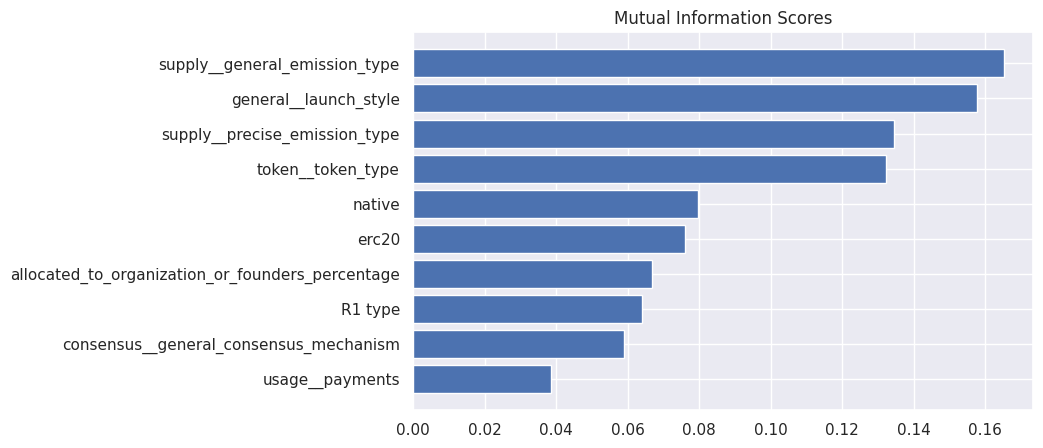

In [34]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(10))

Recheck data

In [35]:
descriptive_table(cleaned_assets).head(5)

,count,mean,std,min,25%,50%,75%,max
current_marketcap_usd,209.0,6.101972e+09,5.044152e+10,3118475.5,27338239.1,120201552.5,5.507598e+08,6.596436e+11
circulating,209.0,5.546765e+09,2.005907e+10,91121.3,66588888.0,288094211.0,1.165282e+09,1.840668e+11
percent_change_last_1_week,209.0,-8.700000e+00,8.100000e+00,-32.2,-12.1,-9.4,-5.600000e+00,2.720000e+01
percent_change_btc_last_1_week,209.0,1.000000e+00,8.900000e+00,-25.0,-2.8,0.2,4.400000e+00,4.060000e+01
percent_change_eth_last_1_week,209.0,2.000000e-01,8.900000e+00,-25.5,-3.5,-0.5,3.700000e+00,3.960000e+01


#### categorizing performance

In [36]:
marketcap_conditions = [
    (cleaned_assets['current_marketcap_usd'] < 27338239.1),
    (cleaned_assets['current_marketcap_usd'] >= 27338239.1) & (cleaned_assets['current_marketcap_usd'] < 120201552.5),
    (cleaned_assets['current_marketcap_usd'] >= 120201552.5) & (cleaned_assets['current_marketcap_usd'] < 5.507598e+08),
    (cleaned_assets['current_marketcap_usd'] >= 5.507598e+08)
]
marketcap_categories = ['low', 'medium', 'high','very high']
cleaned_assets['marketcap_categories'] = np.select(marketcap_conditions, marketcap_categories)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Average marketcap per year

In [37]:
# get average marketcap per year
cleaned_assets["MedianMarketcap_yearly"] = (
    cleaned_assets.groupby("start_year")
    ["current_marketcap_usd"]
    .transform("median")
) 

cleaned_assets[["start_year", "current_marketcap_usd", "MedianMarketcap_yearly"]].head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,start_year,current_marketcap_usd,MedianMarketcap_yearly
0,2009.0,6.596436e+11,1.342765e+09
1,2014.0,3.091416e+11,5.861808e+08
3,2017.0,5.818232e+10,1.124840e+08
6,2020.0,2.632893e+10,2.037711e+08
7,2017.0,2.513058e+10,1.124840e+08
8,2019.0,2.133582e+10,5.030024e+08
11,2013.0,1.666530e+10,5.090272e+07
12,2020.0,1.444531e+10,2.037711e+08
13,2020.0,1.334395e+10,2.037711e+08
16,2018.0,8.496035e+09,5.337451e+07


In [38]:
cleaned_assets.head()

,asset,current_marketcap_usd,circulating,percent_change_last_1_week,percent_change_btc_last_1_week,percent_change_eth_last_1_week,percent_change_month_to_date,percent_change_quarter_to_date,percent_change_year_to_date,sharpe_ratios__last_30_days,volatility_stats__volatility_last_30_days,token__token_type,general__launch_style,supply__general_emission_type,supply__precise_emission_type,supply__is_capped_supply,consensus__general_consensus_mechanism,PROOF-OF-WORK,DELEGATED PROOF-OF-STAKE,HYBRID POW & POS,"PROOF-OF-STAKE, DAG",DAG,"PROOF-OF-WORK, OTHER","PROOF-OF-STAKE, OTHER",HYBRID POW & DPOS,allocated_to_investors_percentage,allocated_to_organization_or_founders_percentage,erc20,native,omni,trc20,trc10,bep2,bep20,erc777,ardor,spl,eosio,usage__payments,usage__work,usage__access,usage__discount,usage__vote,usage__dividends,start_year,R1 type,marketcap_categories,MedianMarketcap_yearly
0,bitcoin,6.596436e+11,1.903264e+07,-9.569280,0.000000,-0.700324,-9.569280,-24.850741,-27.116804,-3.751188,0.543354,Native,Fair Launch,Inflationary,Decreasing Issuance,True,PROOF-OF-WORK,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2009.0,R1_type_not_specied,very high,1.342765e+09
1,ethereum,3.091416e+11,1.206741e+08,-8.935813,0.704918,0.000000,-8.935813,-25.565467,-31.695333,-3.073505,0.584664,Native,Crowdsale,Inflationary,Fixed Issuance,False,PROOF-OF-WORK,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.47,16.53,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2014.0,R1_type_not_specied,very high,5.861808e+08
3,bnb,5.818232e+10,1.632770e+08,-8.226820,1.488970,0.773797,-8.226820,-20.096473,-32.159224,-2.236757,0.563889,"Native, ERC-20",Crowdsale,Deflationary,Non-programmatic burn,True,DELEGATED PROOF-OF-STAKE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,50.00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2017.0,R1_type_not_specied,very high,1.124840e+08
6,solana,2.632893e+10,3.346929e+08,-11.688968,-2.339706,-3.027899,-11.688968,-41.131020,-55.785941,-4.076844,0.856930,Native,"Auctions, Private Sale",Inflationary,Decreasing Inflation rate,False,PROOF-OF-STAKE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.00,25.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020.0,Private,very high,2.037711e+08
7,cardano,2.513058e+10,3.382026e+10,-5.503159,4.500979,3.764581,-5.503159,-35.993120,-45.931638,-3.228148,0.971809,Native,Crowdsale,Inflationary,Decreasing Issuance,True,PROOF-OF-STAKE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.33,16.67,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2017.0,ICO,very high,1.124840e+08


In [39]:
cleaned_assets.shape

(209, 48)

In [40]:
categorized_df = cleaned_assets.drop(columns=['current_marketcap_usd','asset'])
categorized_df.head(3)

,circulating,percent_change_last_1_week,percent_change_btc_last_1_week,percent_change_eth_last_1_week,percent_change_month_to_date,percent_change_quarter_to_date,percent_change_year_to_date,sharpe_ratios__last_30_days,volatility_stats__volatility_last_30_days,token__token_type,general__launch_style,supply__general_emission_type,supply__precise_emission_type,supply__is_capped_supply,consensus__general_consensus_mechanism,PROOF-OF-WORK,DELEGATED PROOF-OF-STAKE,HYBRID POW & POS,"PROOF-OF-STAKE, DAG",DAG,"PROOF-OF-WORK, OTHER","PROOF-OF-STAKE, OTHER",HYBRID POW & DPOS,allocated_to_investors_percentage,allocated_to_organization_or_founders_percentage,erc20,native,omni,trc20,trc10,bep2,bep20,erc777,ardor,spl,eosio,usage__payments,usage__work,usage__access,usage__discount,usage__vote,usage__dividends,start_year,R1 type,marketcap_categories,MedianMarketcap_yearly
0,1.903264e+07,-9.569280,0.000000,-0.700324,-9.569280,-24.850741,-27.116804,-3.751188,0.543354,Native,Fair Launch,Inflationary,Decreasing Issuance,True,PROOF-OF-WORK,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2009.0,R1_type_not_specied,very high,1.342765e+09
1,1.206741e+08,-8.935813,0.704918,0.000000,-8.935813,-25.565467,-31.695333,-3.073505,0.584664,Native,Crowdsale,Inflationary,Fixed Issuance,False,PROOF-OF-WORK,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.47,16.53,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2014.0,R1_type_not_specied,very high,5.861808e+08
3,1.632770e+08,-8.226820,1.488970,0.773797,-8.226820,-20.096473,-32.159224,-2.236757,0.563889,"Native, ERC-20",Crowdsale,Deflationary,Non-programmatic burn,True,DELEGATED PROOF-OF-STAKE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,50.00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2017.0,R1_type_not_specied,very high,1.124840e+08


# Dropping more columns that potentially can leak data

In [41]:
drop_more_cols = ['percent_change_last_1_week','percent_change_btc_last_1_week','percent_change_eth_last_1_week','volatility_stats__volatility_last_30_days','sharpe_ratios__last_30_days','percent_change_year_to_date','percent_change_quarter_to_date','percent_change_month_to_date']
categorized_df = categorized_df.drop(drop_more_cols,axis=1)

retry mutual info

In [42]:
X = categorized_df.copy()
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
y = X.pop('marketcap_categories')
discrete_features = X.dtypes == int

In [43]:
# y = X.pop('marketcap_categories')

# # # Label encoding for categoricals
# # for colname in X.select_dtypes("object"):
# #     X[colname], _ = X[colname].factorize()

# # All discrete features should now have integer dtypes (double-check this before using MI!)
# discrete_features = X.dtypes == int

In [44]:
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

In [45]:
mi_scores.head(14)

general__launch_style                               0.199340
supply__precise_emission_type                       0.173510
token__token_type                                   0.122752
allocated_to_organization_or_founders_percentage    0.096663
R1 type                                             0.089546
consensus__general_consensus_mechanism              0.077425
supply__general_emission_type                       0.075523
start_year                                          0.071003
native                                              0.070286
circulating                                         0.053726
usage__work                                         0.049129
usage__dividends                                    0.047501
DELEGATED PROOF-OF-STAKE                            0.040251
supply__is_capped_supply                            0.039554
Name: MI Scores, dtype: float64

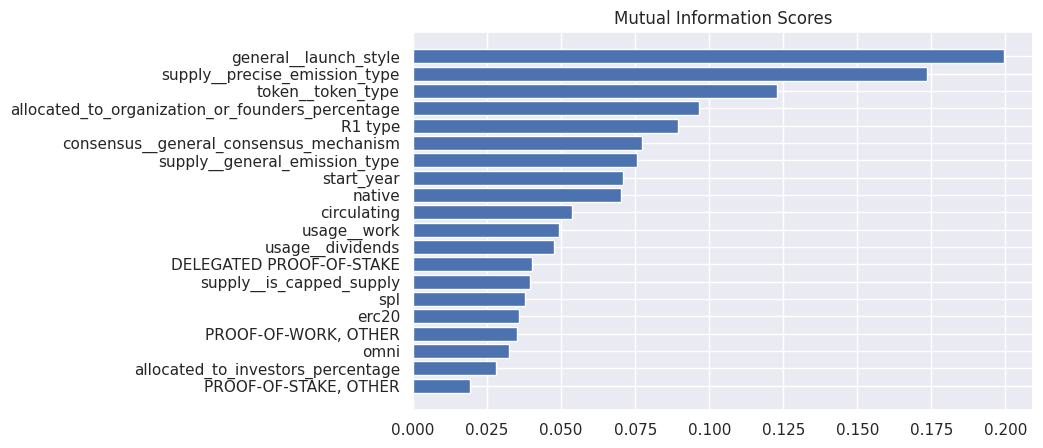

In [46]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

# EDA

In [47]:
cleaned_assets['logged_marketcap'] = np.log(cleaned_assets["current_marketcap_usd"]) # scales better

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0.98, 'Marketcap of coins by token type')

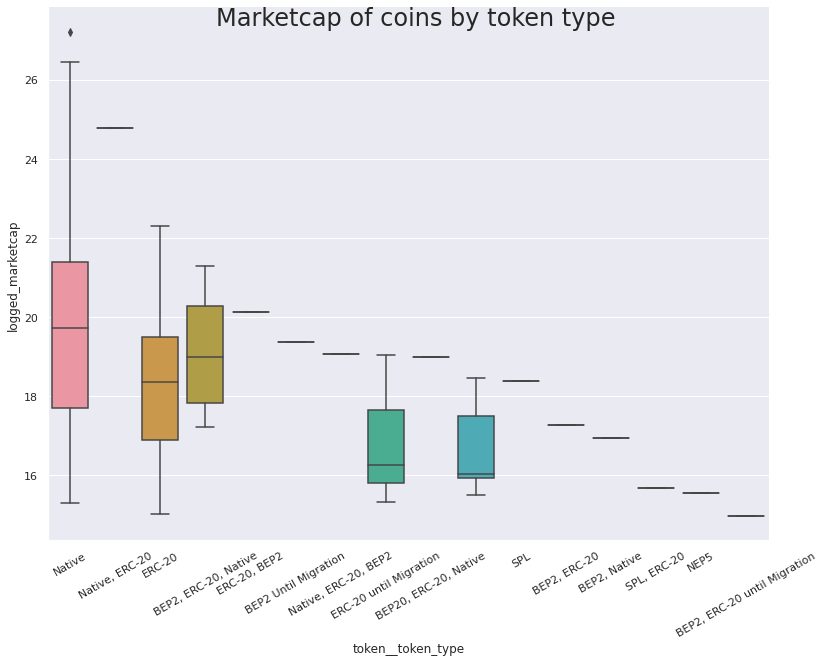

In [48]:
ax = sns.catplot(x="token__token_type", y="logged_marketcap", kind="box",data=cleaned_assets, height=8.27, aspect=11.7/8.27)
ax.set_xticklabels(rotation=30)
ax.fig.suptitle("Marketcap of coins by token type",
                  fontsize=24, fontdict={"weight": "bold"})

In [49]:
# median market cap based on launch style
# get average marketcap per year
categorized_df["MedianMarketcap_network"] = (
    combined_df.groupby("token__token_type")
    ["current_marketcap_usd"]
    .transform("median")
) 

#categorized_df[["token__token_type", "MedianMarketcap_network"]]

Text(0, 0.5, 'Market cap')

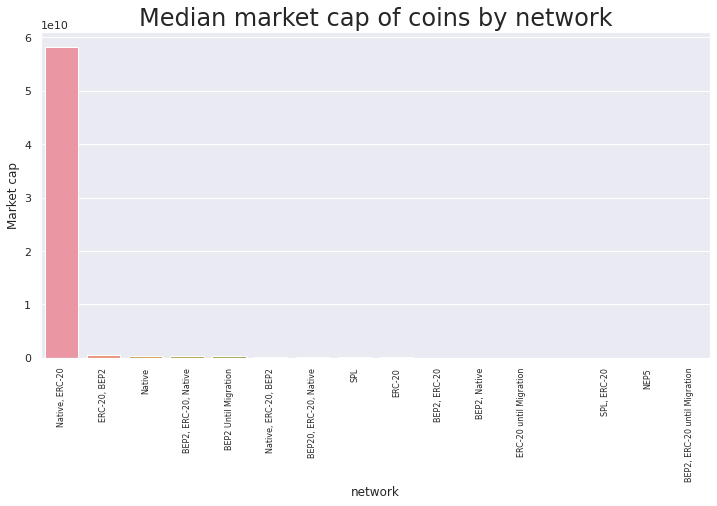

In [50]:
ax = sns.barplot(x="token__token_type", y="MedianMarketcap_network", data=categorized_df.sort_values(by='MedianMarketcap_network',ascending=False))
plt.xticks(rotation=90,fontsize=8)
plt.gcf().set_size_inches(12,6)
plt.title("Median market cap of coins by network",fontsize=24)
plt.xlabel('network',fontsize=12)
plt.ylabel('Market cap',fontsize=12)

Text(0.5, 0.98, 'Marketcap of coins by year')

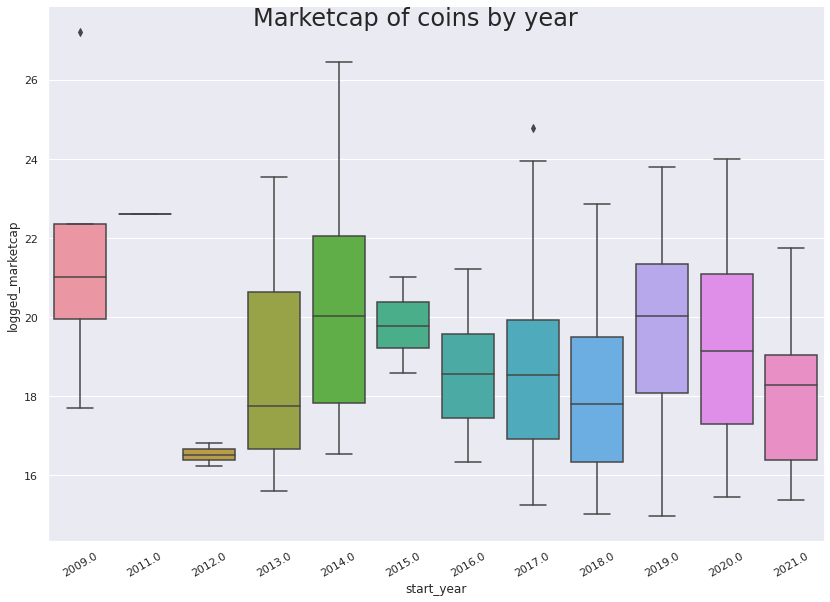

In [51]:
ax = sns.catplot(x="start_year", y="logged_marketcap", kind="box",data=cleaned_assets, height=8.27, aspect=11.7/8.27)
ax.set_xticklabels(rotation=30)
ax.fig.suptitle("Marketcap of coins by year",
                  fontsize=24, fontdict={"weight": "bold"})

Text(0.5, 1.0, 'Current Median Marketcap of coins by their start year')

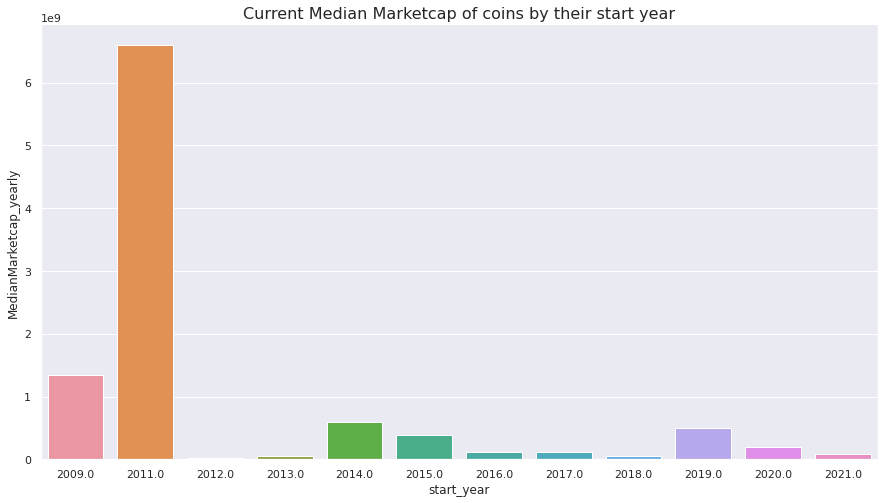

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.barplot(data=cleaned_assets, x="start_year", y="MedianMarketcap_yearly")
ax.set_title("Current Median Marketcap of coins by their start year", loc="center",fontsize=16)
# annotate largest coin per year

Text(0.5, 0.98, 'Marketcap of coins by general launch style')

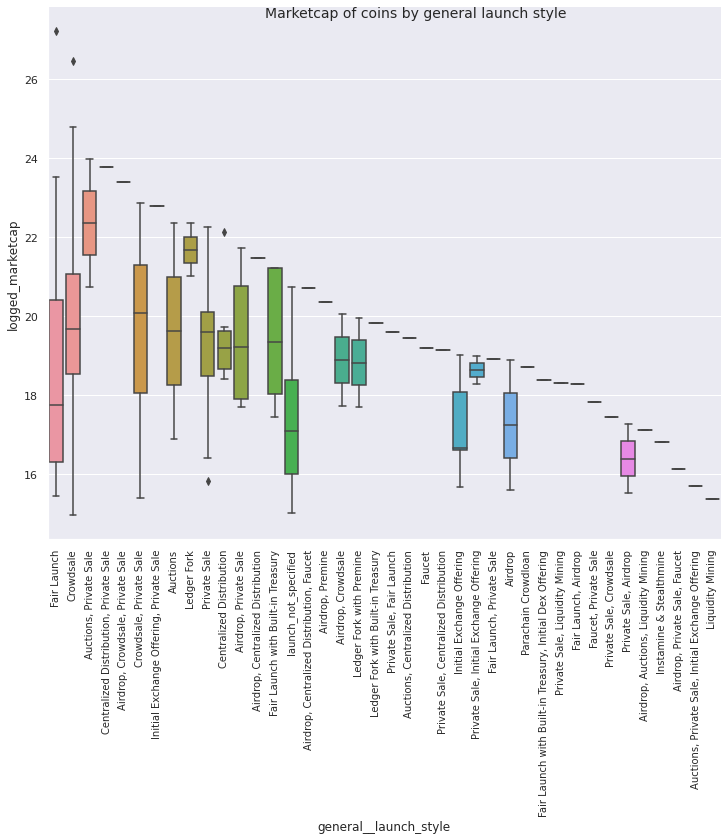

In [53]:
ax = sns.catplot(x="general__launch_style", y="logged_marketcap", kind="box",data=cleaned_assets, height=8.27, aspect=11.7/8.27)
ax.set_xticklabels(rotation=90,fontsize=10)
ax.fig.suptitle("Marketcap of coins by general launch style",
                  fontsize=14, fontdict={"weight": "bold"})

In [54]:
# median market cap based on launch style
categorized_df["MedianMarketcap_launchstyle"] = (
    combined_df.groupby("general__launch_style")
    ["current_marketcap_usd"]
    .transform("median")
) 

categorized_df[["general__launch_style", "MedianMarketcap_launchstyle"]].head(10)

,general__launch_style,MedianMarketcap_launchstyle
0,Fair Launch,5.050224e+07
1,Crowdsale,3.532605e+08
3,Crowdsale,3.532605e+08
6,"Auctions, Private Sale",1.366692e+10
7,Crowdsale,3.532605e+08
8,"Centralized Distribution, Private Sale",2.133582e+10
11,Fair Launch,5.050224e+07
12,"Airdrop, Crowdsale, Private Sale",1.444531e+10
13,Crowdsale,3.532605e+08
16,"Crowdsale, Private Sale",5.316205e+08


Text(0, 0.5, 'Market cap')

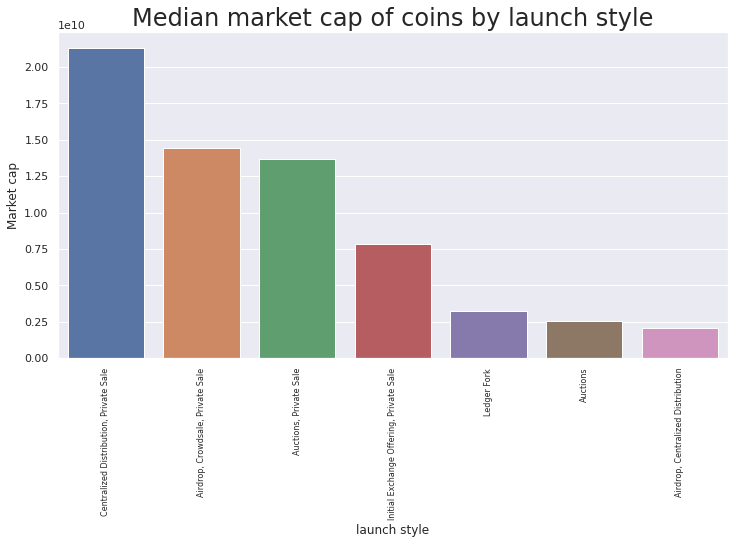

In [55]:
ax = sns.barplot(x="general__launch_style", y="MedianMarketcap_launchstyle", data=categorized_df.sort_values(by='MedianMarketcap_launchstyle',ascending=False).head(10))
plt.xticks(rotation=90,fontsize=8)
plt.gcf().set_size_inches(12,6)
plt.title("Median market cap of coins by launch style",fontsize=24)
plt.xlabel('launch style',fontsize=12)
plt.ylabel('Market cap',fontsize=12)

Text(0.5, 0.98, 'Marketcap of coins by general emission type')

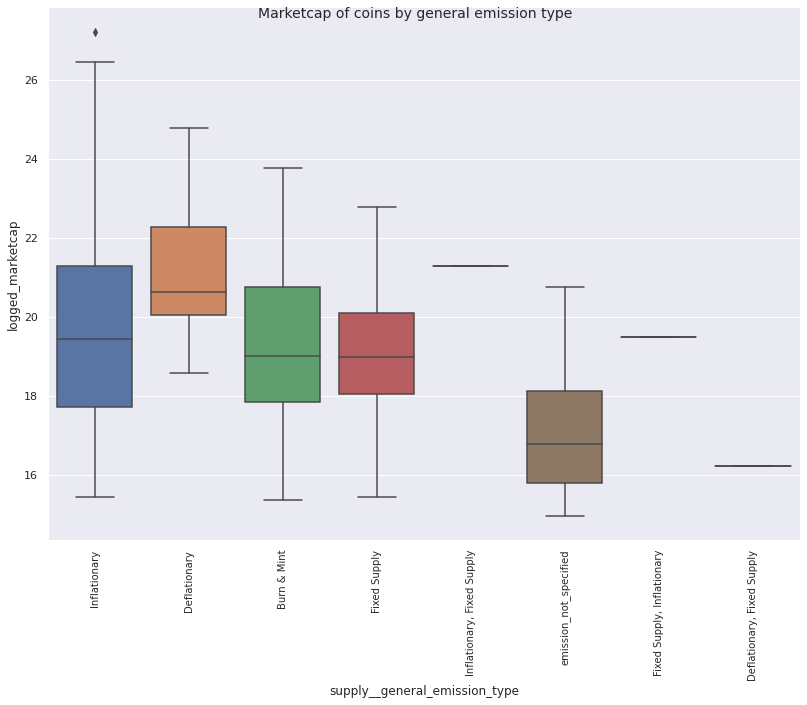

In [56]:
#categorized_df['supply__general_emission_type'].value_counts()
ax = sns.catplot(x="supply__general_emission_type", y="logged_marketcap", kind="box",data=cleaned_assets, height=8.27, aspect=11.7/8.27)
ax.set_xticklabels(rotation=90,fontsize=10)
ax.fig.suptitle("Marketcap of coins by general emission type",
                  fontsize=14, fontdict={"weight": "bold"})

In [57]:
# median market cap based on emission type 
# get average marketcap per year
categorized_df["MedianMarketcap_emissiontype"] = (
    combined_df.groupby("supply__general_emission_type")
    ["current_marketcap_usd"]
    .transform("median")
) 

#categorized_df[["general__launch_style", "MedianMarketcap_emissiontype"]].head(10)

Text(0, 0.5, 'Market cap')

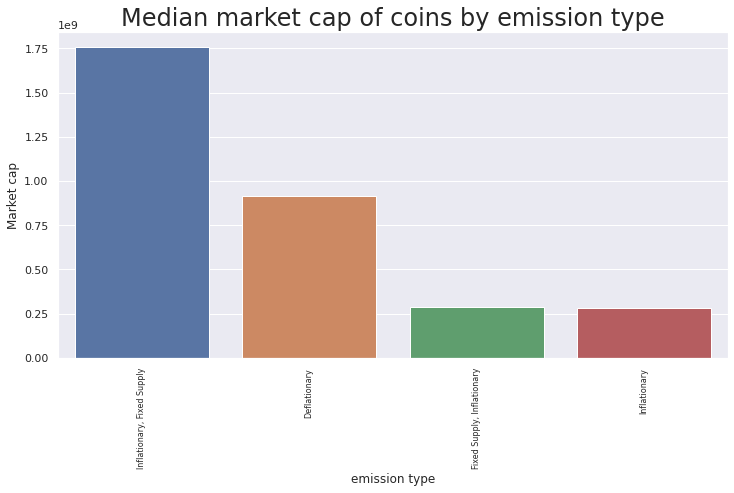

In [58]:
ax = sns.barplot(x="supply__general_emission_type", y="MedianMarketcap_emissiontype", data=categorized_df.sort_values(by='MedianMarketcap_emissiontype',ascending=False).head(10))
plt.xticks(rotation=90,fontsize=8)
plt.gcf().set_size_inches(12,6)
plt.title("Median market cap of coins by emission type",fontsize=24)
plt.xlabel('emission type',fontsize=12)
plt.ylabel('Market cap',fontsize=12)

In [59]:
categorized_df["MedianMarketcap_precise_emissiontype"] = (
    combined_df.groupby("supply__precise_emission_type")
    ["current_marketcap_usd"]
    .transform("median")
) 

Text(0, 0.5, 'Median Market cap')

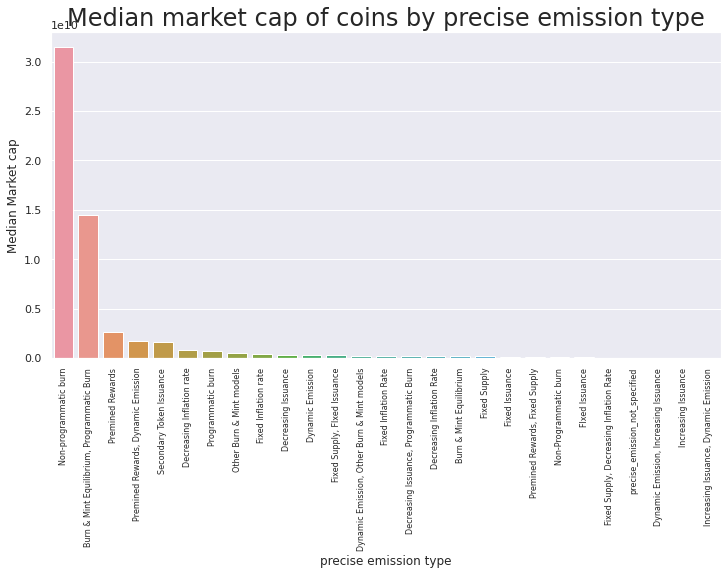

In [60]:
ax = sns.barplot(x="supply__precise_emission_type", y="MedianMarketcap_precise_emissiontype", data=categorized_df.sort_values(by='MedianMarketcap_precise_emissiontype',ascending=False))
plt.xticks(rotation=90,fontsize=8)
plt.gcf().set_size_inches(12,6)
plt.title("Median market cap of coins by precise emission type",fontsize=24)
plt.xlabel('precise emission type',fontsize=12)
plt.ylabel('Median Market cap',fontsize=12)

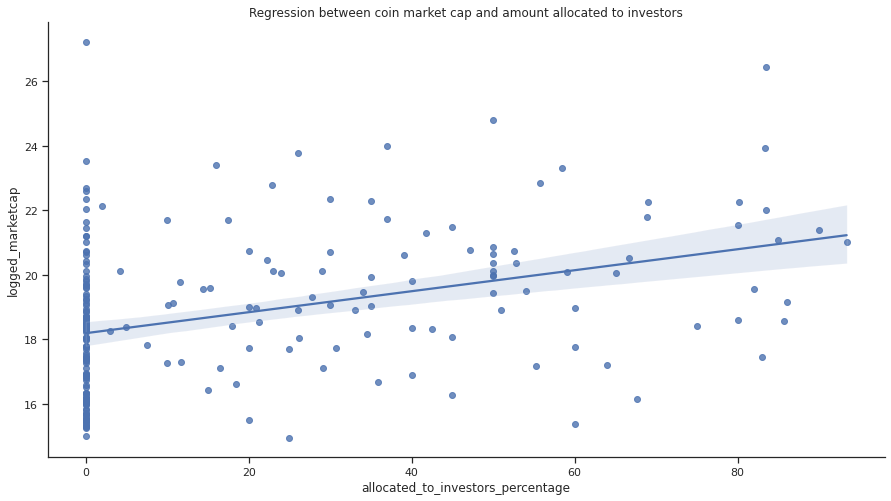

In [61]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.regplot(x="allocated_to_investors_percentage", y="logged_marketcap", ax=ax,data=cleaned_assets)
ax.set_title("Regression between coin market cap and amount allocated to investors", loc="center")
sns.despine()

#ax = sns.regplot(x="allocated_to_investors_percentage", x="allocated_to_investors_percentage", data=cleaned_assets)

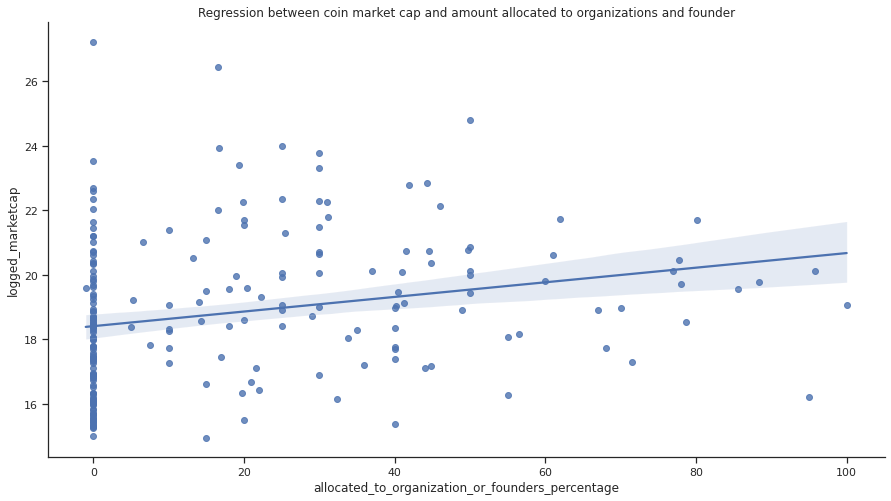

In [62]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.regplot(x="allocated_to_organization_or_founders_percentage", y="logged_marketcap", ax=ax,data=cleaned_assets)
ax.set_title("Regression between coin market cap and amount allocated to organizations and founder", loc="center")
sns.despine()


## Removing 0s from founder

In [63]:
alloc_founders = cleaned_assets[['asset','allocated_to_organization_or_founders_percentage','current_marketcap_usd','logged_marketcap']]

alloc_founders  = alloc_founders[alloc_founders['allocated_to_organization_or_founders_percentage'] != 0]
alloc_founders.shape

(107, 4)

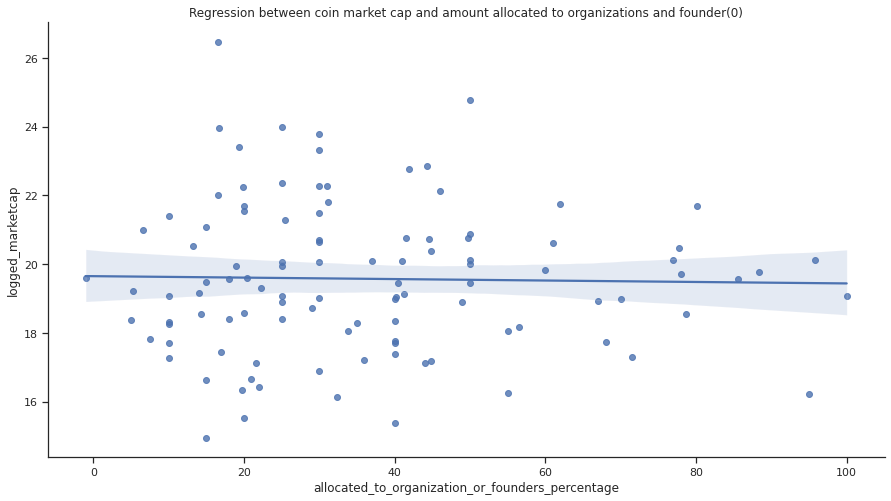

In [64]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.regplot(x="allocated_to_organization_or_founders_percentage", y="logged_marketcap", ax=ax,data=alloc_founders)
ax.set_title("Regression between coin market cap and amount allocated to organizations and founder(0)", loc="center")
sns.despine()

## removing 0s from investors

In [65]:
alloc_invest = cleaned_assets[['asset','allocated_to_investors_percentage','current_marketcap_usd','logged_marketcap']]
alloc_invest  = alloc_invest[alloc_invest['allocated_to_investors_percentage'] != 0]
alloc_invest.shape

(99, 4)

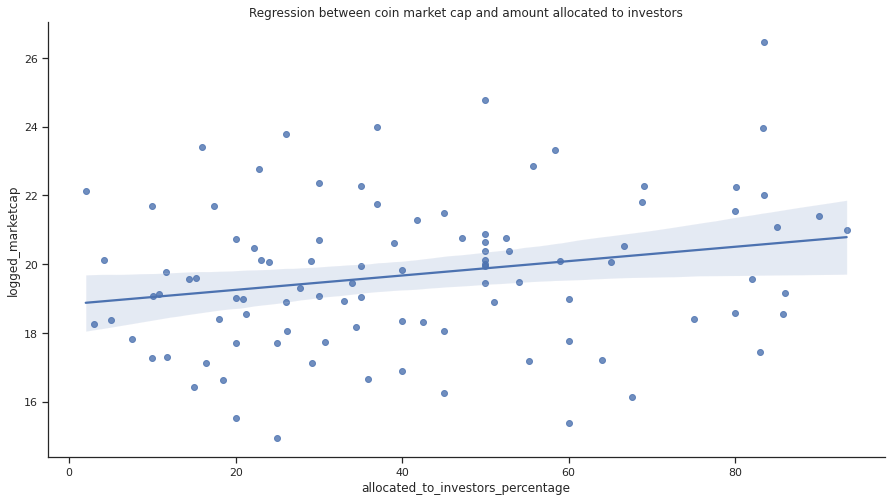

In [66]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.regplot(x="allocated_to_investors_percentage", y="logged_marketcap", ax=ax,data=alloc_invest)
ax.set_title("Regression between coin market cap and amount allocated to investors", loc="center")
sns.despine()


# Build  1st model

In [67]:
X = cleaned_assets.copy()
X = X.drop(drop_more_cols,axis=1) # data leak cols
X = X.drop(columns=['logged_marketcap','current_marketcap_usd','asset','circulating','token__token_type','marketcap_categories']) # target

# Flagging different vars

In [68]:
X = pd.concat([X, X['general__launch_style'].str.get_dummies(sep=',')], axis=1)
X = pd.concat([X, X['supply__general_emission_type'].str.get_dummies(sep=',')], axis=1)
X = pd.concat([X, X['supply__precise_emission_type'].str.get_dummies(sep=',')], axis=1)
X = pd.concat([X, X['supply__is_capped_supply'].str.get_dummies(sep=',')], axis=1)
X = pd.concat([X, X['R1 type'].str.get_dummies(sep=',')], axis=1)

# Drop flagged categories

In [69]:
X = X.drop(columns=['general__launch_style','supply__general_emission_type',
                    'supply__precise_emission_type','supply__is_capped_supply',
                    'R1 type','consensus__general_consensus_mechanism'])

# Label encode target variable

In [70]:
#label_encoder = LabelEncoder()
#cleaned_assets['marketcap_categories'] = label_encoder.fit_transform(cleaned_assets['marketcap_categories'])

#split our dataset

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

y = cleaned_assets[['marketcap_categories']]
X = X.loc[:,~X.columns.duplicated()] # certain cols were duplicates
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1,shuffle=True)

# scale our variables

In [72]:
# scaler = StandardScaler()
# scaler.fit(train_X)  # No cheating, never scale on the training+test!
# train_X = scaler.transform(train_X)
# val_X = scaler.transform(val_X)



# Random Forest

In [73]:
my_model = RandomForestClassifier(n_estimators=8000,
                                 random_state=23).fit(train_X, train_y.values.ravel())
y_pred = my_model.predict(val_X)
print("Accuracy:",metrics.accuracy_score(val_y, y_pred))

Accuracy: 0.32075471698113206


# Xgboost

In [74]:
#  grid search to find optimal hyper parameters
# gbm_param_grid = {
#     'learning_rate' : [0.07,0.06],
#     'colsample_bytree': [0.8,0.7],
#     'n_estimators': [50,100.75],
#     'max_depth': [10,15],
#     'gamma' : [0.1,1,5],
#     'objective': ['multi:softmax']
# } 

# xgb_model = xgb.XGBClassifier()
# grid_acc = GridSearchCV(estimator=xgb_model,param_grid=gbm_param_grid, cv=4, verbose=1)
# grid_acc.fit(X,y.values.ravel())

# print("Best parameters found: ", grid_acc.best_params_)
# print( "best score : ",grid_acc.best_score_)

In [75]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', n_estimators=50,
                              learning_rate=0.07,max_depth=10,gamma=5,colsample_bytree=0.7)

xgb_model.fit(train_X, train_y.values.ravel())
y_pred = xgb_model.predict(val_X)

In [76]:
print("Accuracy:",metrics.accuracy_score(val_y, y_pred))

Accuracy: 0.49056603773584906


# XGBoost confusion matrix

In [92]:
print(confusion_matrix(val_y,y_pred))
print(classification_report(val_y,y_pred))

[[ 7  1  0  2]
 [ 7  7  0  0]
 [ 7  4  0  2]
 [ 3  1  0 12]]
              precision    recall  f1-score   support

        high       0.29      0.70      0.41        10
         low       0.54      0.50      0.52        14
      medium       0.00      0.00      0.00        13
   very high       0.75      0.75      0.75        16

    accuracy                           0.49        53
   macro avg       0.40      0.49      0.42        53
weighted avg       0.42      0.49      0.44        53



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [97]:
class_labels = list(val_y['marketcap_categories'].unique())
class_labels = ['high','low','medium','very high']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


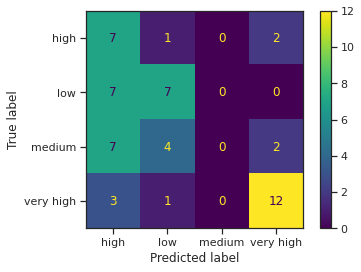

In [78]:
plot_confusion_matrix(xgb_model, val_X, val_y)  
plt.show()

# Eli5 aka feature importance random forest

In [79]:
import eli5
from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
# eli5.show_weights(perm, feature_names = val_X.columns.tolist())

# Eli5 aka feature importance xgboost

In [80]:
perm = PermutationImportance(xgb_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.1736 ± 0.1249,emission_not_specified
0.0981 ± 0.0282,native
0.0679 ± 0.0912,MedianMarketcap_yearly
0.0566 ± 0.0000,allocated_to_investors_percentage
0.0453 ± 0.0385,Private Sale
0.0302 ± 0.0302,Fixed Supply
0.0038 ± 0.0282,usage__payments
0 ± 0.0000,Airdrop
0 ± 0.0000,Auctions
0 ± 0.0000,Centralized Distribution


# random forest feature importance

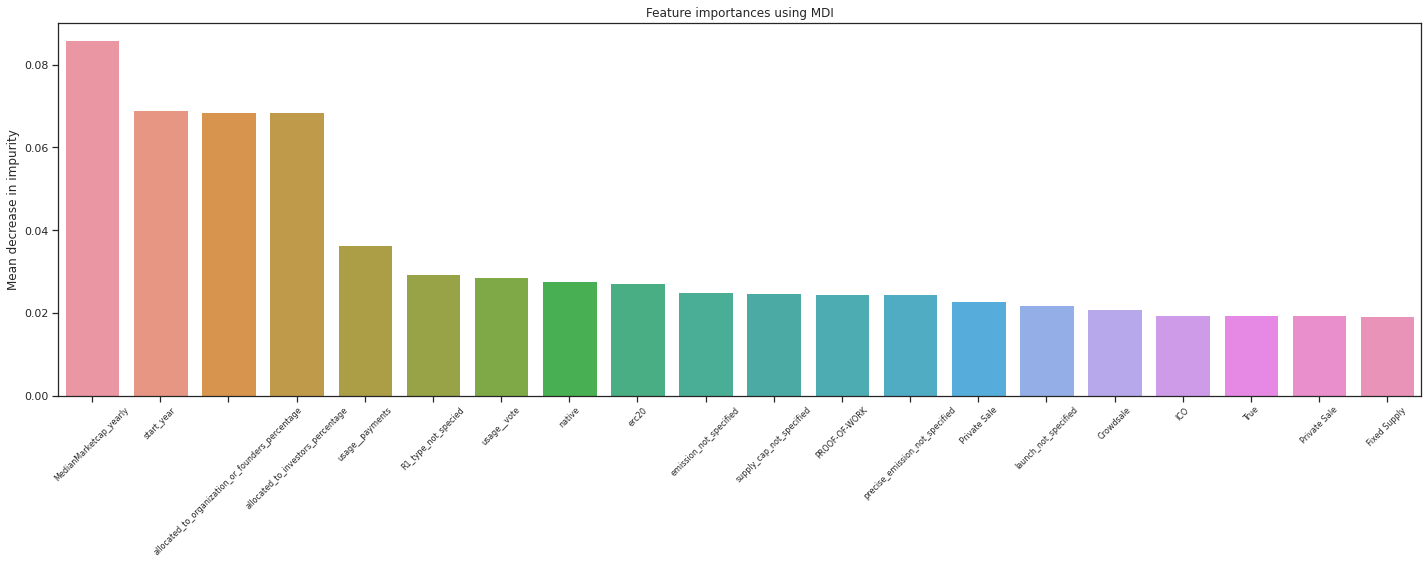

In [81]:
feature_names = X.columns
importances = my_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in my_model.estimators_], axis=0)


forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(20)

fig, ax = plt.subplots()
#forest_importances.plot.bar(ax=ax)
ax = sns.barplot(x=forest_importances.index, y=forest_importances.values)
plt.xticks(rotation=45,fontsize=8)
plt.gcf().set_size_inches(20,8)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


# Xgboost feature importance

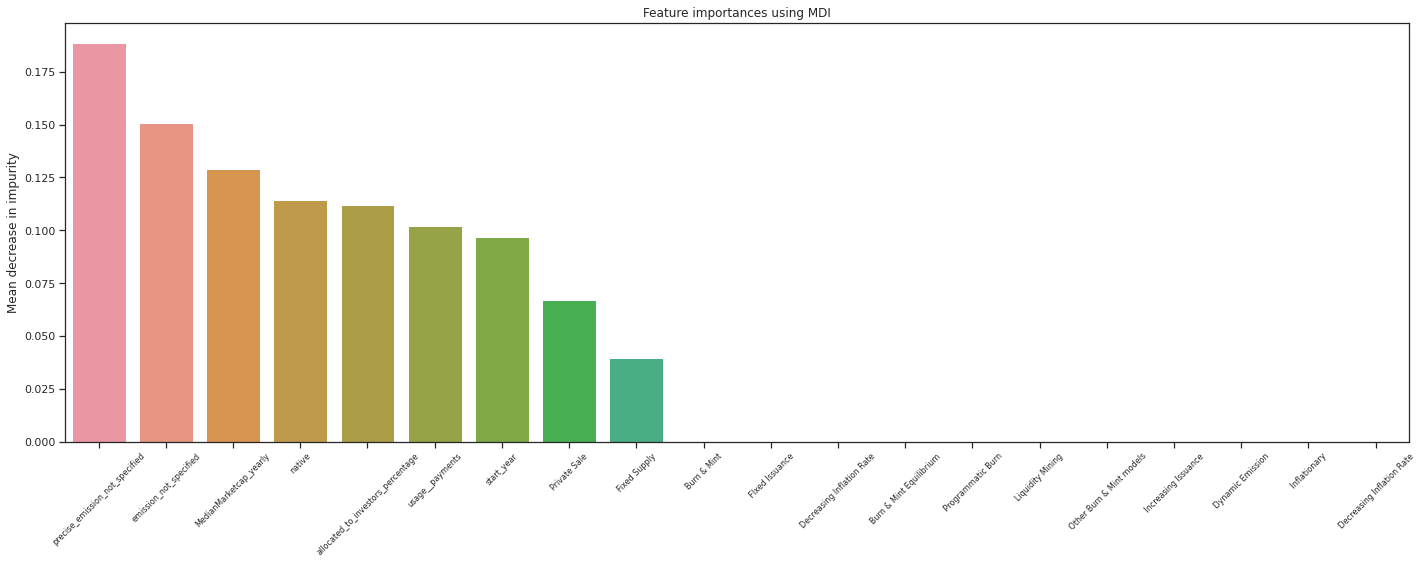

In [82]:
feature_names = X.columns
importances = xgb_model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in xgb_model.estimators_], axis=0)


forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(20)

fig, ax = plt.subplots()
#forest_importances.plot.bar(ax=ax)
ax = sns.barplot(x=forest_importances.index, y=forest_importances.values)
plt.xticks(rotation=45,fontsize=8)
plt.gcf().set_size_inches(20,8)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


# Shap values

In [95]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

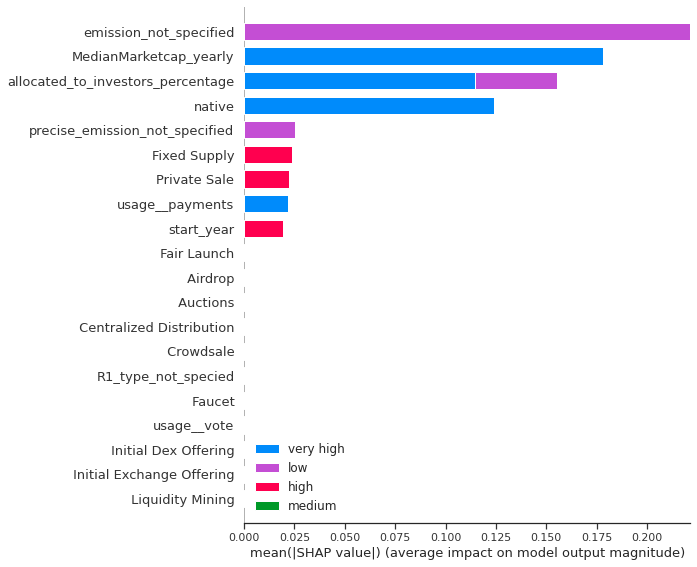

In [98]:
shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= class_labels, feature_names = X.columns)

In [101]:
class_labels

['high', 'low', 'medium', 'very high']

## how our model decides to classify a token with very high market cap

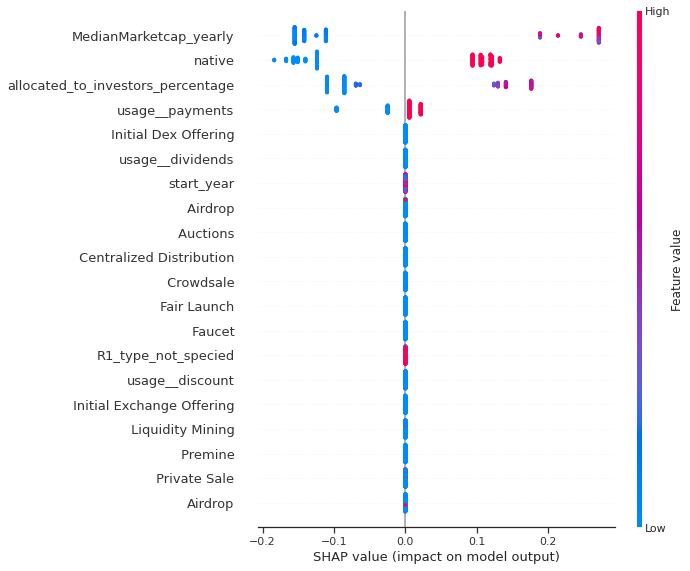

In [103]:
shap.summary_plot(shap_values[3], X.values, feature_names = X.columns)

In [83]:
# explore more feautre interactions
# dependence plot
# shap 
# https://www.kaggle.com/code/saikiranputta/ted-eda-with-partial-dependence-plots-using-rf/notebook